# Explore Casas-Ibarra flavor space

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from configrun_IDM import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import *
import commands
import sys
import time
import re
import os


def Lambda(Mk,mH0,mA0):
    '''Loop funtion, defined for each neutral triplet component'''
    return (Mk/(16*pi**2))*((mH0**2/(mH0**2-Mk**2))*np.log(mH0**2/Mk**2) -(mA0**2/(mA0**2-Mk**2))*np.log(mA0**2/Mk**2)  )


def neutrino_data(CL=3,IH=False):
    import numpy as np
    '''From arxiv:1405.7540 (table I)
    and asumming a Normal Hierarchy:
    Output:
    mnu1in: laightest neutrino mass
    Dms2: \Delta m^2_{12}
    Dma2: \Delta m^2_{13}
    ThetSol,ThetAtm,ThetRec: in radians
    '''
    if CL==3:
        Dms2=np.array([7.11e-5, 7.60e-5, 8.18e-5])*1e-18 # In GeV
        Dma2=np.array([2.30e-3, 2.48e-3, 2.65e-3])*1e-18 # In GeV
        if IH:
            Dma2=np.array([2.20e-3, 2.38e-3, 2.54e-3])*1e-18 # In GeV
        #input real values:
        #
        ThetSol = np.array([0.278,  0.323,  0.375]) 
        ThetAtm = np.array([0.393,  0.567,  0.643])
        if IH:
            ThetAtm = np.array([0.403,  0.573,  0.640])
        ThetRec = np.array([0.0190, 0.0226, 0.0262])
        if IH:
            ThetRec = np.array([0.0193, 0.0229, 0.0265])
            
        delta=np.array([0,np.pi,2.*np.pi])
    elif CL==1:
        Dms2=np.array([7.42e-5, 7.60e-5, 7.79e-5])*1e-18 # In GeV
        Dma2=np.array([2.41e-3, 2.48e-3, 2.53e-3])*1e-18 # In GeV
        if IH:
            Dma2=np.array([2.32e-3, 2.38e-3, 2.43e-3])*1e-18 # In GeV
        #input real values:
        #
        ThetSol = np.array([0.307,  0.323,  0.339]) 
        ThetAtm = np.array([0.443,  0.567,  0.599])
        if IH:
            ThetAtm = np.array([0.534,  0.573,  0.598])
        ThetRec = np.array([0.0214, 0.0226, 0.0238])
        if IH:
            ThetRec = np.array([0.0217, 0.0229, 0.0241])
        delta=np.array([1.01*np.pi,1.41*np.pi,1.96*np.pi])
        if IH:
            delta=np.array([1.17*np.pi,1.48*np.pi,1.79*np.pi])
    mnu1in=1E-5*1E-9

    return mnu1in,Dms2,Dma2,ThetSol,ThetAtm,ThetRec,delta

def casasibarra(di,norotate1=False,norotate2=False,norotate3=False,bestfit=False,\
                nophases=False,massless_nulight=False,min_nulight=1E-9,max_nulight=0.5,\
                IH=False,R_complex=True,min_angle=0,CL=3):
    """
    min_nulight=1E-9,
    max_nulight=0.5 in eV: pdg neutrino review
       NH: nu1<nu2<nu3
    We assume mass ordering for Heavy particles but inverse hierarchy (IH) for neutrinos could imply:
       IH: nu3<nu1<nu2
    di.keys()-> ['MH0','MA0','Mtr01','Mtr02','Mtr03',]
    """
    import numpy as np
    import pandas as pd
    di=pd.Series(di)
    if massless_nulight:
        norotate2=True #R13=1
        if not IH:
            #cos(t_2)=R_{12}; sin(t_2)=R_{13}
            #sqrt(m_2)cos(t_2)U^*_{i2}+sqrt(m_3)sin(t_2)U^*_{i3}
            #-sqrt(m_2)sin(t_2)U^*_{i2}+sqrt(m_3)cos(t_2)U^*_{i3}
            norotate1=True #R12=1
        else:
            #cos(t_1)=R_{11}; sin(t_1)=R_{12}
            #sqrt(m_1)cos(t_1)U^*_{i1}+sqrt(m_2)sin(t_1)U^*_{i2}
            #-sqrt(m_2)sin(t_1)U^*_{i1}+sqrt(m_2)cos(t_1)U^*_{i2}
            norotate3=True #R23=1
        
        
    
    ignore,Dms2,Dma2,ThetSol,ThetAtm,ThetRec,deltaD=neutrino_data(CL=CL,IH=IH) 

    
    #Inverse MR masses. M^R_3 -> infty corresponds to zero entry
    Mtr01t=1.*(0. if massless_nulight and IH==False else 1./np.abs(Lambda(di.Mtr01,di.MH0,di.MA0)) )
    Mtr02t=1./np.abs(Lambda(di.Mtr02,di.MH0,di.MA0))
    Mtr03t=1.*(0. if massless_nulight and IH==True else 1./np.abs(Lambda(di.Mtr03,di.MH0,di.MA0)) )
    
    
    DMR=np.asarray([ [np.sqrt( Mtr01t),0,0],[0,np.sqrt(Mtr02t),0],[0,0,np.sqrt(Mtr03t)] ]   )
    
    #phases of the PMNS matrix
    
    delta=1.*(0 if nophases else np.random.uniform(deltaD[0],deltaD[2]))
    eta1 =1.*(0 if nophases else np.random.uniform(0.,np.pi)) 
    eta2 =1.*(0 if nophases else np.random.uniform(0.,np.pi))
    if bestfit:
        delta=deltaD[1]
    
    if not IH:
        mnu1=1.*(0. if massless_nulight else np.exp(np.random.uniform(np.log(min_nulight),np.log(max_nulight)))*1e-9 ) 
        #m_3=m_3^2-m_1^2+m_1^2
        mnu3=1.*(np.sqrt(Dma2[1]+mnu1**2)     if bestfit else  np.sqrt(np.random.uniform(Dma2[0],Dma2[2]) + mnu1**2) )
    else:
        mnu3=1.*(0. if massless_nulight else np.exp(np.random.uniform(np.log(min_nulight),np.log(max_nulight)))*1e-9 )
        #m_1=|m_3^2-m_1^2|+m_3^2=m_1^2-m_3^2+m_3^2=
        mnu1=1.*(np.sqrt(Dma2[1]+mnu3**2)     if bestfit else  np.sqrt(np.random.uniform(Dma2[0],Dma2[2]) + mnu3**2) )

    #m_2=m_2^2-m_1^2+m_1^2    
    mnu2=1.*(np.sqrt(Dms2[1]+mnu1**2)     if bestfit else  np.sqrt(np.random.uniform(Dms2[0],Dms2[2]) + mnu1**2) ) 


    #light neutrino masses only for an estimation 
    #mnu1=0
    #mnu2=sqrt(8.2e-5*1e-18+mnu1**2)
    #mnu3=sqrt(2.74e-3*1e-18+mnu1**2)
    
    #Square root of left-handed nuetrino mass matrix 
    DMnu=np.asarray([ [np.sqrt(mnu1),0,0],[0,np.sqrt(mnu2),0],[0,0,np.sqrt(mnu3)] ])
    
    #mixing angles using 3 sigma data from arxiv:1405.7540 (table I)                        
    #and asumming a Normal Hierarchy'''



    t12 = 1.*( np.arcsin(np.sqrt(ThetSol[1])) if bestfit else np.arcsin(np.sqrt(np.random.uniform(ThetSol[0],ThetSol[2]))))
    t23 = 1.*( np.arcsin(np.sqrt(ThetAtm[1])) if bestfit else np.arcsin(np.sqrt(np.random.uniform(ThetAtm[0],ThetAtm[2]))))
    t13 = 1.*( np.arcsin(np.sqrt(ThetRec[1])) if bestfit else np.arcsin(np.sqrt(np.random.uniform(ThetRec[0],ThetRec[2]))))
    
    
    #Building PMNS matrix: http://pdg.lbl.gov/2014/reviews/rpp2014-rev-neutrino-mixing.pdf
    
    U12 = np.array([ [np.cos(t12),np.sin(t12),0], [-np.sin(t12),np.cos(t12),0], [0,0,1.0] ])
    U13 = np.array([ [np.cos(t13),0,np.sin(t13)*np.exp(-delta*1j)], [0,1.0,0],\
                     [-np.sin(t13)*np.exp(delta*1j),0,np.cos(t13)] ])
    U23 = np.array([ [1.0,0,0], [0,np.cos(t23),np.sin(t23)], [0,-np.sin(t23),np.cos(t23)] ])
    Uphases = np.diag([1.,np.exp(eta1*1j/2.),np.exp(eta2*1j/2.)])
    U=((U23.dot(U13)).dot(U12)).dot(Uphases)
    #print U-np.dot(U23,np.dot(U13,np.dot(U12,Uphases)))
    #Building R matrix of the Casas-Ibarra parametrization
    
    
    min_real=min_angle
    max_real=2.*np.pi
    phases2=np.random.uniform(min_real,max_real ,3) 
    if R_complex:
        min_imag=1E-12
        max_imag=20. #2E-1
        phases2=phases2+1j*np.exp(np.random.uniform(\
                            np.log(min_imag),np.log(max_imag) ,3) )*np.random.choice([1,-1])
    

    b12 = 1.*(0 if norotate1 else phases2[0])
    b13 = 1.*(0 if norotate2 else phases2[1])
    b23 = 1.*(0 if norotate3 else phases2[2])
    
  
    # R 
    R12 = array([ [np.cos(b12),np.sin(b12),0], [-np.sin(b12),np.cos(b12),0], [0,0,1.0] ])
    R13 = array([ [np.cos(b13),0,np.sin(b13)], [0,1.0,0], [-np.sin(b13),0,np.cos(b13)] ])
    R23 = array([ [1.0,0,0], [0,np.cos(b23),np.sin(b23)], [0,-np.sin(b23),np.cos(b23)] ])
    R=dot(R23,dot(R13,R12))
    #1assert(np.abs(np.dot(R, R.transpose()))[1,2]<1E-10)
    #Yukawa matrix of the Casas-Ibarra parametrization
    yuk2=dot(DMR,dot(R,dot(DMnu,transpose(conjugate(U)))))
    return yuk2,U,DMnu.dot(DMnu),phases2


        
def test_casasibarra():
    ci={'MH0':53.,'MH':125.3,'MA0':120.,'MH1':130.,'La2':0.01,'LaL':0.001,'Mtr01':91.,\
        'Mtr02':92.,'Mtr03':93,'Mtrch1': 91.8,'Mtrch2': 92.8, 'Mtrch3': 93.8}

    #mnu1in,Dms2,Dma2,ThetSol,ThetAtm,ThetRec=neutrino_data()
    #Mnuin=np.array([mnu1in,np.sqrt(Dms2[1]+mnu1in**2),np.sqrt(Dma2[1]+mnu1in**2)])
    mnu1in=1E-5
    
    h,U,Mnuin,phases=casasibarra(ci,norotate1=True,norotate2=True,norotate3=True,bestfit=True,\
                nophases=True,min_nulight=mnu1in,max_nulight=mnu1in)
    
    Lamb = np.array([[Lambda(ci['Mtr01'],ci['MH0'],ci['MA0']),0,0],\
                     [0,Lambda(ci['Mtr02'],ci['MH0'],ci['MA0']),0],\
                     [0,0,Lambda(ci['Mtr03'],ci['MH0'],ci['MA0'])]])

    
    Mint = np.dot( h.transpose(),np.dot(Lamb,h) )
    Mnu,U=np.linalg.eig(Mint) 
    lo=np.argsort(np.abs(Mnu))
    Mnu=np.array([Mnu[lo[0]],Mnu[lo[1]],Mnu[lo[2]]])
    U=np.matrix(U)
    U=np.asarray(np.hstack((U[:,lo[0]],U[:,lo[1]],U[:,lo[2]])))
    print Mnu
    print U
    
    Upmns=np.array([[ 0.81311635+0.j,  0.56164206+0.j,  0.15297059+0.j],\
                    [ 0.46875227+0.j,  0.47596125+0.j,  0.74413184+0.j],\
                    [ 0.34512767+0.j,  0.67677108+0.j,  0.65028286+0.j]])

    print Mnuin
    print Upmns
    np.testing.assert_array_almost_equal(np.abs(Mnuin)*1e9,np.abs(Mnu)*1e9)
    np.testing.assert_array_almost_equal(np.abs(Upmns),np.abs(U))


#if __name__=='__main__':
#    test_casasibarra()

In [3]:
IGNORE_CELL=False
RECOVER_BKP=False
if IGNORE_CELL:
    RECOVER_BKP=True

In [6]:
def Ynorm(dp,norotate1=False,norotate2=False,norotate3=False,bestfit=False,nophases=False,\
             massless_nulight=False,min_nulight=1E-9,max_nulight=0.5,IH=False,R_complex=True,\
             min_angle=1E-12,CL=3):
    '''IH: Inverse Hierarchy
    \Sum_m_nu<0.15 see: http://resonaances.blogspot.com/2014/12/planck-whats-new.html
    '''
    DEBUG=False
    import pandas as pd
    dp=pd.Series(dp)
    x=pd.Series()
    yuk,U,Mnu,phases = casasibarra(dp,norotate1=norotate1,norotate2=norotate2,norotate3=norotate2,bestfit=bestfit,\
                       nophases=nophases,massless_nulight=massless_nulight,min_nulight=min_nulight,\
                       max_nulight=max_nulight,IH=IH,R_complex=R_complex,min_angle=min_angle,CL=CL) 
    
    #print np.real(yuk[0,:])
    #print np.imag(yuk[0,:])
    
    Lamb = np.array([[Lambda(dp['Mtr01'],dp['MH0'],dp['MA0']),0,0],\
                     [0,Lambda(dp['Mtr02'],dp['MH0'],dp['MA0']),0],\
                     [0,0,Lambda(dp['Mtr03'],dp['MH0'],dp['MA0'])]])

    Yi_LOP=np.abs(yuk[0,:])
    if massless_nulight:
        Yi_LOP=np.abs(yuk[1,:])
        Yi_HOP=np.abs(yuk[1,:])
    x=x.append(dp)
    x=x.append(pd.Series(dict(zip(['y1e','y1mu','y1tau'],Yi_LOP))))
    x=x.append(pd.Series(dict(zip(['y2e','y2mu','y2tau'],np.abs(yuk[1,:])))))
    x=x.append(pd.Series(dict(zip(['y3e','y3mu','y3tau'],np.abs(yuk[2,:])))))
    h=yuk
    Mint = np.dot( h.transpose().conjugate(),np.dot(Lamb,h) )
    for i in range(1,4):
        for s in ['e','mu','tau']: 
            x['Y%d%s' %(i,s)] = x['y%d%s' %(i,s)]/np.sqrt(\
                                x['y%de' %i]**2 + x['y%dmu' %i]**2 +x['y%dtau' %i]**2) 
    
    ##neutrino physics
    v={'e':0,'mu':1,'tau':2}
    w={0:'e',1:'mu',2:'tau'}
    for i in range(3):
        x['m_nu_%d' %(i+1)]=Mnu[i,i]
        x['theta_%d_r' %(i+1)]=phases[i].real
        x['theta_%d_i' %(i+1)]=phases[i].imag
        for s in v.keys():    
            x['U_%s%d_r' %(s,i+1)]=np.real(U)[v['%s' %s],i]
            x['U_%s%d_i' %(s,i+1)]=np.imag(U)[v['%s' %s],i]
        for j in range(3):
            x['M_%s%s' %(w[i],w[j])]=Mint[i,j]
            
        
        

    
    SM=get_config('SM')
    
    if DEBUG:
        h=yuk
        print "*"*10
        Mint = np.dot( h.transpose().conjugate(),np.dot(Lamb,h) )
        Mnu,U=np.linalg.eig(Mint) 
        lo=np.argsort(np.abs(Mnu))
        Mnu=np.array([Mnu[lo[0]],Mnu[lo[1]],Mnu[lo[2]]])
        U=np.matrix(U)
        U=np.asarray(np.hstack((U[:,lo[0]],U[:,lo[1]],U[:,lo[2]])))
        print np.abs(Mnu)*1E9
        print np.abs(U)
        print "*"*10
    
    return x

Massles neutrino

In [7]:
#from heptools import *
dp={'MH0': 70.0, 'MA0':700.0, 'MHC':150., 'Mh':125.09, 'la2':0.01, 'laL':0.001,'Mtr01':300,'Mtr02':1000,'Mtr03':1000}
dp=pd.Series(dp)
xd=pd.DataFrame()
for i in range(1):  
    x=Ynorm(dp,R_complex=True,massless_nulight=True,CL=1)
    xd=xd.append(x,ignore_index=True) 
print xd.m_nu_1[0]**2,xd.m_nu_2[0]**2,xd.m_nu_3[0]**2
xd=pd.DataFrame()
for i in range(1):  
    x=Ynorm(dp,R_complex=True,massless_nulight=True,IH=True,CL=1)
    xd=xd.append(x,ignore_index=True) 
print xd.m_nu_1[0]**2,xd.m_nu_2[0]**2,xd.m_nu_3[0]**2

0j (7.67142196591e-23+0j) (2.46701401633e-21+0j)
(2.35118354653e-21+0j) (2.42637139864e-21+0j) 0j


In [8]:
xd

,MA0,MH0,MHC,M_ee,M_emu,M_etau,M_mue,M_mumu,M_mutau,M_taue,...,theta_3_r,y1e,y1mu,y1tau,y2e,y2mu,y2tau,y3e,y3mu,y3tau
0,(700+0j),(70+0j),(150+0j),(-4.75970388272e-11-1.61558713389e-27j),(-3.5995312068e-12+4.48500697214e-12j),(-2.58686758328e-12+3.79759276796e-12j),(-3.5995312068e-12-4.48500697214e-12j),(-2.1181905354e-11+0j),(2.36206287276e-11+4.34362007163e-14j),(-2.58686758328e-12-3.79759276796e-12j),...,(1.53244597973+0j),(1.3724588337e-06+0j),(1.85840394655e-06+0j),(2.52077504928e-06+0j),(1.3724588337e-06+0j),(1.85840394655e-06+0j),(2.52077504928e-06+0j),0j,0j,0j


Initial point

/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-1, 1)

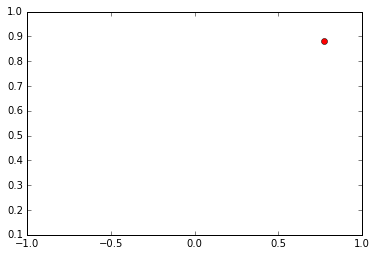

In [9]:
#from heptools import *
dp={'MH0': 70.0, 'MA0':700.0, 'MHC':150., 'Mh':125.09, 'la2':0.01, 'laL':0.001,'Mtr01':300,'Mtr02':1000,'Mtr03':1000}
dp=pd.Series(dp)
xd=pd.DataFrame()
for i in range(1):  
    x=Ynorm(dp,R_complex=True,bestfit=True,nophases=True,massless_nulight=True,IH=True,CL=1)
    xd=xd.append(x,ignore_index=True) 

plt.plot((xd.Y1e**2-xd.Y1mu**2)/(xd.Y1e**2+xd.Y1mu**2),(xd.Y1e**2+xd.Y1mu**2),'ro')
plt.ylim(0.1,1)
plt.xlim(-1,1)
#print xd.Yfe.max(),xd.Yfmu.max(),xd.Yftau.max()

# General run

## Full scan

In [12]:
#cp NH.csv NH_bak.csv

In [28]:
if not IGNORE_CELL:
    ir=range(50000)
    dp={'MH0': 70.0, 'MA0':700.0, 'MHC':150., 'Mh':125.09, 'la2':0.01, 'laL':0.001,'Mtr01':300,'Mtr02':1000,'Mtr03':1000}
    dp=pd.Series(dp)
    xdf=pd.DataFrame()
    xif=pd.DataFrame()
    stu=200
    for i in ir:
        dp.Mtr01=np.random.uniform(100,1000)
        dp.Mtr02=np.random.uniform(dp.Mtr01,3000)
        dp.Mtr03=np.random.uniform(dp.Mtr02,3000)
        dp.MA0=np.random.uniform(dp.MH0,800)
        dp.MHC=(dp.MA0 if dp.MA0>stu else np.random.uniform(70,stu)) #possible restrictions from STU
        x=Ynorm(dp) 
        xdf=xdf.append(x,ignore_index=True)
        y=Ynorm(dp,IH=True)
        xif=xif.append(y,ignore_index=True)


    xdf.to_csv('NH.csv',index=False)
    xif.to_csv('IH.csv',index=False)

In [30]:
xdf.shape

(50000, 66)

In [32]:
RECOVER_BKP=True

In [58]:
if RECOVER_BKP:
    xdf=pd.read_csv('NH.csv')
    xif=pd.read_csv('IH.csv')

In [72]:
xdf=xdf.applymap(np.complex)
xif=xif.applymap(np.complex)

In [73]:
xd=xdf[xdf.mu_to_e_gamma.abs()<5.7E-13]
xdp=xdf[xdf.Yukawa_max.abs()<10]
xi=xif[xif.mu_to_e_gamma.abs()<5.7E-13]
xip=xif[xif.Yukawa_max.abs()<10]

In [78]:
print np.abs(xd.y1e.max()),np.abs(xi.y1e.max())
print np.abs(xd.y1mu.max()),np.abs(xi.y1mu.max())
print np.abs(xd.y1tau.max()),np.abs(xi.y1tau.max())
print np.abs(xd.y2e.max()),np.abs(xi.y2e.max())
print np.abs(xd.y2mu.max()),np.abs(xi.y2mu.max())
print np.abs(xd.y2tau.max()),np.abs(xi.y2tau.max())
print np.abs(xd.y3e.max()),np.abs(xi.y3e.max())
print np.abs(xd.y3mu.max()),np.abs(xi.y3mu.max())
print np.abs(xd.y3tau.max()),np.abs(xi.y3tau.max())

0.183900929489 0.165184260174
0.279960211263 0.310114069208
0.335602352987 0.272706674089
0.427046600647 1.74191882201
2.89355994239 0.648231752297
2.08463711389 1.58816566727
0.430884816486 1.78868299732
2.99245991662 0.648795209189
2.10201968581 1.60805349654


## Triangular plot

arXiv:1403.4294

In [20]:
def triang_x(A,B,C):
    return 1./2.*(2*B+C)/(A+B+C)
def triang_y(A,B,C):
    return np.sqrt(3)/2.*C/(A+B+C)

In [21]:
td=pd.DataFrame()
td=td.append({'ve':1,'vmu':0,'vtau':0},ignore_index=True)
td=td.append({'ve':0,'vnp.abs(mu':1,'vtau':0},ignore_index=True)
td=td.append({'ve':0,'vmu':0,'vtau':1},ignore_index=True)
td=td.append({'ve':1,'vmu':0,'vtau':0},ignore_index=True)

(0, 1)

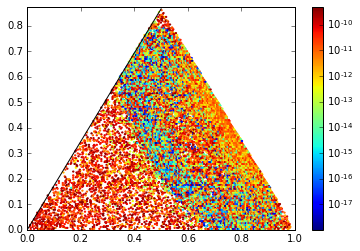

In [79]:
plt.plot(triang_x(td.ve,td.vmu,td.vtau),triang_y(td.ve,td.vmu,td.vtau),'k-')
plt.hexbin(triang_x(xdp.Y1e.abs()**2,xdp.Y1mu.abs()**2,xdp.Y1tau.abs()**2),triang_y(xdp.Y1e.abs()**2,xdp.Y1mu.abs()**2,xdp.Y1tau.abs()**2),np.abs(xdp.m_nu_1.abs()),norm=matplotlib.colors.LogNorm(),gridsize =200)
plt.colorbar()
plt.ylim(0,1.01*np.sqrt(3.)/2.)
plt.xlim(0,1)

## Inverse hierarchy

(0, 1)

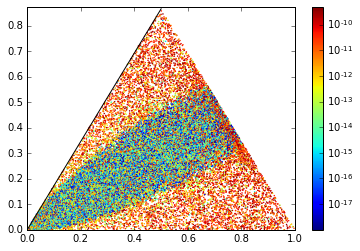

In [80]:
plt.plot(triang_x(td.ve,td.vmu,td.vtau),triang_y(td.ve,td.vmu,td.vtau),'k-')
plt.hexbin(triang_x(xip.Y1e.abs()**2,xip.Y1mu.abs()**2,xip.Y1tau.abs()**2),triang_y(xip.Y1e.abs()**2,xip.Y1mu.abs()**2,xip.Y1tau.abs()**2),np.abs(xip.m_nu_3.abs()),norm=matplotlib.colors.LogNorm(),gridsize =500)
plt.colorbar()
plt.ylim(0,1.01*np.sqrt(3.)/2.)
plt.xlim(0,1)

In [81]:
from triangleplot import *
def flavorplot(df,IH=False,savepdf=False):
    
    if IH==True:
        nui=3
    else:
        nui=1
    
    x=triang_x(df.Y1e**2,df.Y1mu**2,df.Y1tau**2)
    y=triang_y(df.Y1e**2,df.Y1mu**2,df.Y1tau**2)
    z=np.log10(np.abs(df['m_nu_%d' %nui])*1E9)
    logmnu=range(int(round(z.min(),2)),\
                      int(round(z.max(),2)))
    triangleplot(x,y,z,levels=logmnu,scale='log',title=r'$m_%d$ (eV)' %nui,\
                 xlabel=r'$\mathcal{B}_e$',ylabel=r'$\mathcal{B}_\mu$',zlabel=r'$\mathcal{B}_\tau$')
    if savepdf:
        if IH:
            plt.savefig('IH.pdf')
        else:
            plt.savefig('NH.pdf')



We have checked that the same result is obtained for fixed masses and real rotation matrix

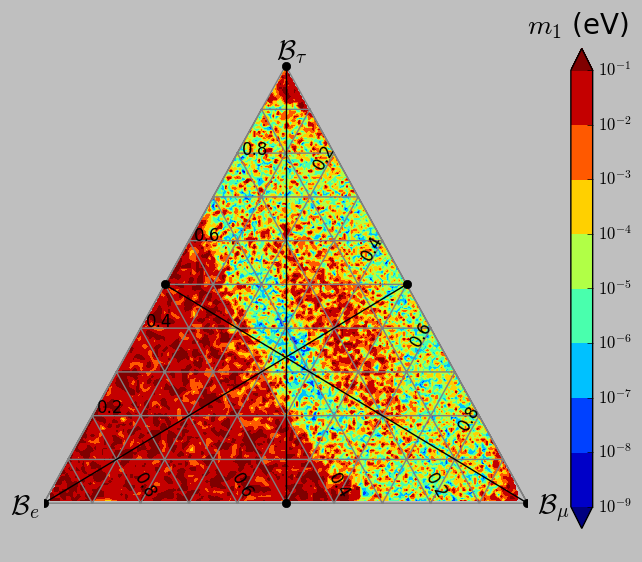

In [82]:
flavorplot(xdp.abs(),savepdf=False)

(166, 67)

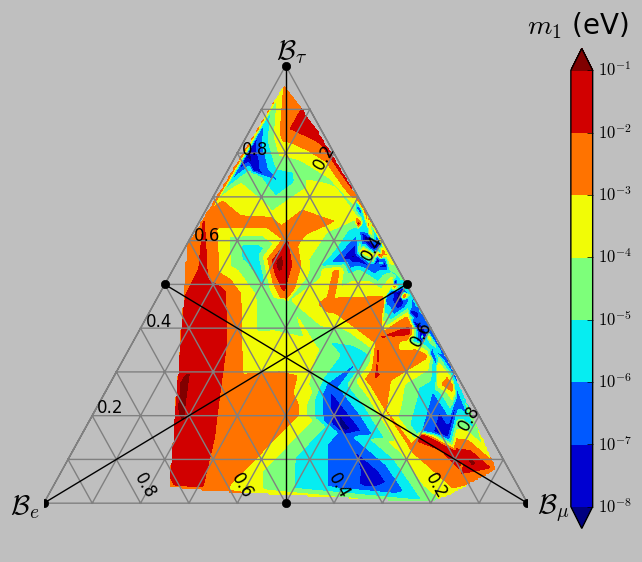

In [89]:
xdpa=xdp.abs()
smin=0.95;smax=1.05
xdpa=xdpa.reset_index(drop=True)
xmutau=xdpa[np.logical_and(np.abs(xdpa.M_emu/xdpa.M_etau)>smin,np.abs(xdpa.M_emu/xdpa.M_etau)<smax)]
xmutau=xmutau[np.logical_and(np.abs(xmutau.M_mumu/xdp.M_tautau)>smin,np.abs(xmutau.M_mumu/xdp.M_tautau)<smax)]
flavorplot(xmutau,savepdf=False)
xmutau.shape

(912, 67)

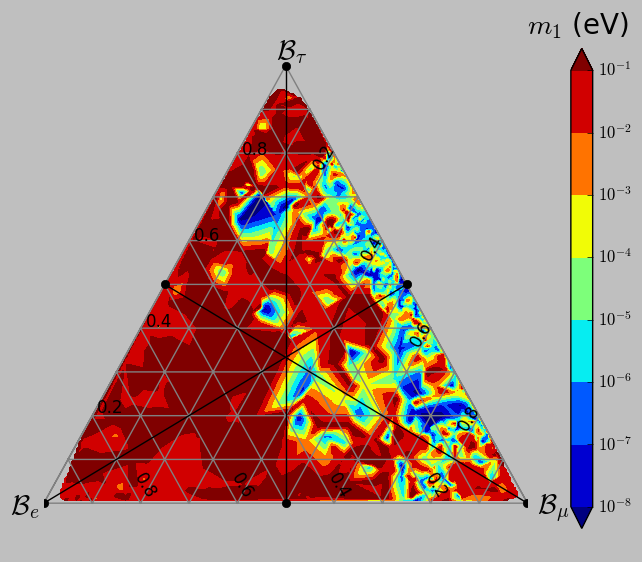

In [126]:
xdpa=xdp.abs()
#xdpa.fillna(0)
smin=2;smax=2
xdpa=xdpa.reset_index(drop=True)
xmutau=xdpa[np.abs(xdpa.M_emu/xdpa.M_etau)>smax]
xmutau=xmutau[np.abs(xmutau.M_mumu/xdp.M_tautau)>smax]
flavorplot(xmutau,savepdf=False)
xmutau.shape

In [105]:
np.abs(xdpa.M_emu/xdpa.M_etau).min()

0.0092238948705508535

In [107]:
np.abs(xmutau.M_mumu/xdp.M_tautau).min()

2.81678828808084e-14

In [57]:
xdp.columns

Index([u'MA0', u'MH0', u'MHC', u'M_ee', u'M_emu', u'M_etau', u'M_mue',
       u'M_mumu', u'M_mutau', u'M_taue', u'M_taumu', u'M_tautau', u'Mh',
       u'Mtr01', u'Mtr02', u'Mtr03', u'U_e1_i', u'U_e1_r', u'U_e2_i',
       u'U_e2_r', u'U_e3_i', u'U_e3_r', u'U_mu1_i', u'U_mu1_r', u'U_mu2_i',
       u'U_mu2_r', u'U_mu3_i', u'U_mu3_r', u'U_tau1_i', u'U_tau1_r',
       u'U_tau2_i', u'U_tau2_r', u'U_tau3_i', u'U_tau3_r', u'Y1e', u'Y1mu',
       u'Y1tau', u'Y2e', u'Y2mu', u'Y2tau', u'Y3e', u'Y3mu', u'Y3tau',
       u'Yukawa_max', u'la2', u'laL', u'm_nu_1', u'm_nu_2', u'm_nu_3',
       u'mu_to_e_gamma', u'tau_to_mu_gamma', u'theta_1_i', u'theta_1_r',
       u'theta_2_i', u'theta_2_r', u'theta_3_i', u'theta_3_r', u'y1e', u'y1mu',
       u'y1tau', u'y2e', u'y2mu', u'y2tau', u'y3e', u'y3mu', u'y3tau'],
      dtype='object')

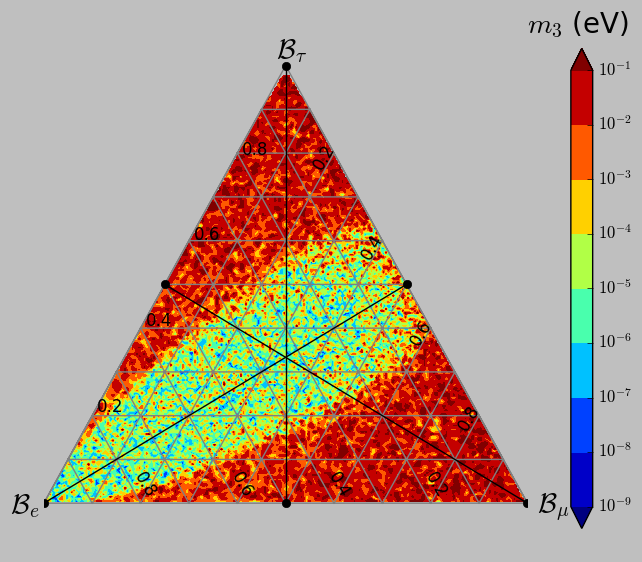

In [63]:
flavorplot(xip,IH=True,savepdf=False)

(2263, 67)

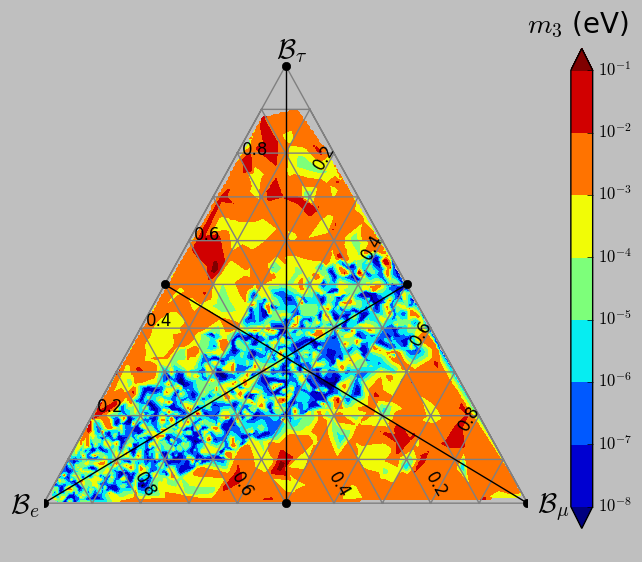

In [94]:
xdpa=xip.abs()
smin=0.9;smax=1.1
xdpa=xdpa.reset_index(drop=True)
xmutau=xdpa[np.logical_and(np.abs(xdpa.M_emu/xdpa.M_etau)>smin,np.abs(xdpa.M_emu/xdpa.M_etau)<smax)]
xmutau=xmutau[np.logical_and(np.abs(xmutau.M_mumu/xdp.M_tautau)>smin,np.abs(xmutau.M_mumu/xdp.M_tautau)<smax)]
flavorplot(xmutau,IH=True,savepdf=False)
xmutau.shape

(1361, 67)

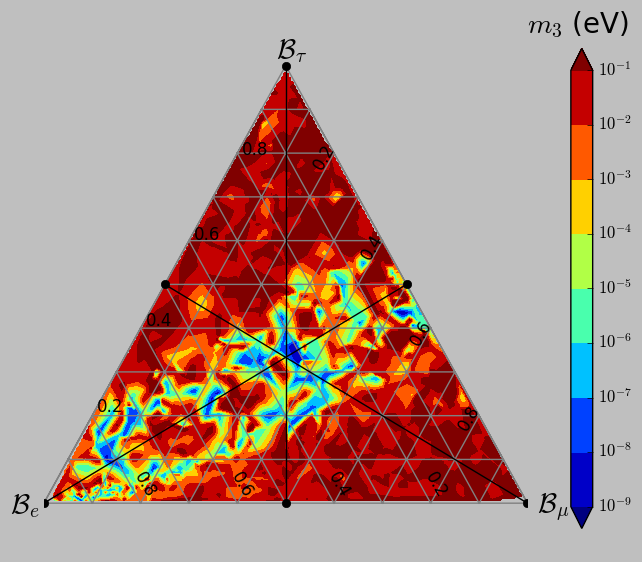

In [133]:
xdpa=xip.abs()
smin=0.9;smax=1.7
xdpa=xdpa.reset_index(drop=True)
xmutau=xdpa[np.abs(xdpa.M_emu/xdpa.M_etau)>smax]
xmutau=xmutau[np.abs(xmutau.M_mumu/xdp.M_tautau)>smax]
flavorplot(xmutau,IH=True,savepdf=False)
xmutau.shape

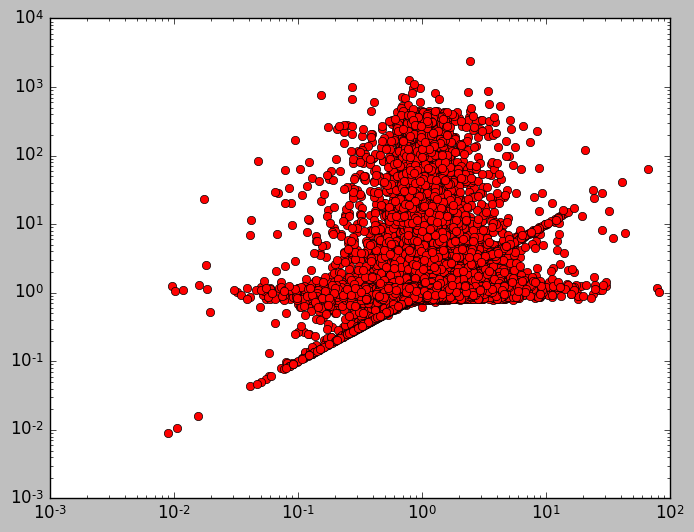

In [64]:
plt.hexbin(np.abs(xip.M_emu/xip.M_etau),np.abs(xip.M_mumu/xip.M_mutau),xip.)

## Width 

In [20]:
def G_Sigmap_to_Hp_lm(M_Sigmap,M_Hp,Yuk):
    '''arXiv:0703080 and http://arxiv.org/pdf/0805.1613.pdf
    http://www.mpi-hd.mpg.de/lin/seminar_theory/talks/hambye.pdf
    http://arxiv.org/pdf/1107.3463v3.pdf
    http://www.hri.res.in/~nuhorizons/nuhri3/upload/MMitra.pdf'''
    import numpy as np
    #if x<y:
    #    f=0.
    #else:    
    return  (M_Sigmap/(32.0*np.pi))*np.abs(Yuk)**2*( 1.0- (M_Hp/M_Sigmap)**2 )**2
    #return f

In [21]:
SM=pd.Series(get_config('SM'))
xdp['Gammap_Hp_em']=G_Sigmap_to_Hp_lm(xdf.Mtr01,xdf.MHC,xdf.y1e)
xdp['Gammap_Hp_mum']=G_Sigmap_to_Hp_lm(xdf.Mtr01,xdf.MHC,xdf.y1mu)
xdp['Gammap_Hp_taum']=G_Sigmap_to_Hp_lm(xdf.Mtr01,xdf.MHC,xdf.y1tau)
DeltaM=166E-3
xdp['Gamma_Sigma0_pip']=2.*SM.G_F**2*SM.V_ud**2*DeltaM**3*SM.f_pi**2*np.sqrt(1-SM.m_pipm**2/DeltaM**2)/np.pi
xdp['B_Sigmap_to_Hp_em']=xdp['Gammap_Hp_em']/(xdp['Gammap_Hp_em']+xdp['Gammap_Hp_mum']+xdp['Gammap_Hp_taum'])
xdp['B_Sigmap_to_Sigma0_pip']=xdp['Gammap_Hp_em']/(xdp['Gammap_Hp_em']+xdp['Gammap_Hp_mum']+xdp['Gammap_Hp_taum'])

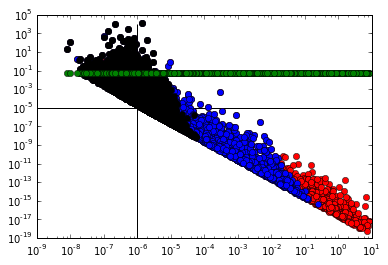

In [22]:
xg=xdp[xdp.Mtr01>xdp.MHC]
xgmg=xg[xg.mu_to_e_gamma<5.7E-13]
xgmgs=xg[xg.mu_to_e_gamma<1E-26]

plt.loglog(xg.y1e,SM.hbarc/xg.Gammap_Hp_em,'ro')
plt.loglog(xgmg.y1e,SM.hbarc/xgmg.Gammap_Hp_em,'bo')
plt.loglog(xgmgs.y1e,SM.hbarc/xgmgs.Gammap_Hp_em,'ko')
plt.loglog(xg.y1e,SM.hbarc/xg.Gamma_Sigma0_pip,'go')
plt.hlines(1E-5,1E-9,10)
plt.vlines(1E-6,1E-19,1E4)

In [ ]:
plt.loglog(xg.y1e,xg.B_Sigmap_to_Hp_em,'ro')
plt.loglog(xg.y1e,xg.B_Sigmap_to_Hp_em,'ro')

## Hierarchy plot

See: http://arxiv.org/pdf/1301.1340v2.pdf and PDG review

(1e-14, 1e-09)

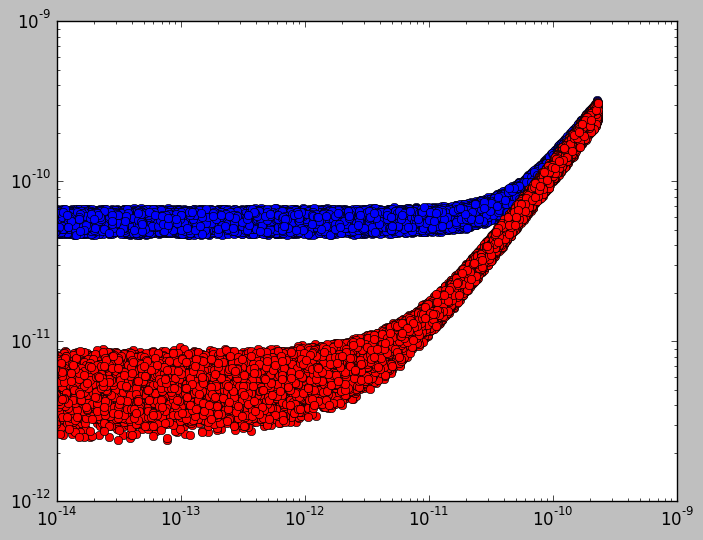

In [17]:
xdf['mee']=np.abs( (xdf.U_e1_r+xdf.U_e1_i)**2*xdf.m_nu_1
                +  (xdf.U_e2_r+xdf.U_e2_i)**2*xdf.m_nu_2
                +  (xdf.U_e3_r+xdf.U_e3_i)**2*xdf.m_nu_3 )
xif['mee']=np.abs( (xif.U_e1_r+xif.U_e1_i)**2*xif.m_nu_1
                +  (xif.U_e2_r+xif.U_e2_i)**2*xif.m_nu_2
                +  (xif.U_e3_r+xif.U_e3_i)**2*xif.m_nu_3 )
plt.loglog(xif.m_nu_3,xif.mee,'bo')
plt.loglog(xdf.m_nu_1,xdf.mee,'ro')

plt.xlim(1E-14,1E-9)

In [4]:
%%bash
#git add CIparameterspace.ipynb
git commit -am "Minor changes"

[dark e21a564] Minor changes
 1 file changed, 45 insertions(+), 32 deletions(-)


In [19]:
if 1==1:
    ir=range(50000)
    dp={'MH0': 70.0, 'MA0':700.0, 'MHC':150., 'Mh':125.09, 'la2':0.01, 'laL':0.001,'Mtr01':300,'Mtr02':1000,'Mtr03':1000}
    dp=pd.Series(dp)
    xdf=pd.DataFrame()
    xif=pd.DataFrame()
    stu=200
    for i in ir:
        dp.Mtr01=np.random.uniform(100,1000)
        dp.Mtr02=np.random.uniform(dp.Mtr01,3000)
        dp.Mtr03=np.random.uniform(dp.Mtr02,3000)
        dp.MA0=np.random.uniform(dp.MH0,800)
        dp.MHC=(dp.MA0 if dp.MA0>stu else np.random.uniform(70,stu)) #possible restrictions from STU
        x=Ynorm(dp,massless_nulight=True) 
        xdf=xdf.append(x,ignore_index=True)
        y=Ynorm(dp,massless_nulight=True,IH=True)
        xif=xif.append(y,ignore_index=True)
    xdf.to_csv('NH.csv')
    xif.to_csv('IH.csv')

In [20]:
xd=xdf[xdf.mu_to_e_gamma<5.7E-13]
xdp=xdf[xdf.Yukawa_max<10]
xi=xif[xif.mu_to_e_gamma<5.7E-13]
xip=xif[xif.Yukawa_max<10]

In [21]:
def triang_x(A,B,C):
    return 1./2.*(2*B+C)/(A+B+C)
def triang_y(A,B,C):
    return np.sqrt(3)/2.*C/(A+B+C)

In [22]:
td=pd.DataFrame()
td=td.append({'ve':1,'vmu':0,'vtau':0},ignore_index=True)
td=td.append({'ve':0,'vnp.abs(mu':1,'vtau':0},ignore_index=True)
td=td.append({'ve':0,'vmu':0,'vtau':1},ignore_index=True)
td=td.append({'ve':1,'vmu':0,'vtau':0},ignore_index=True)

In [33]:
xdp.m_nu_3

0     4.998302e-11
1     4.985346e-11
2     4.807623e-11
3     4.825922e-11
4     5.065562e-11
5     4.825691e-11
6     4.924521e-11
7     4.937931e-11
8     5.029323e-11
9     4.964121e-11
10    4.812949e-11
11    5.109807e-11
12    5.127963e-11
13    4.809422e-11
14    5.037817e-11
...
49984    4.986575e-11
49985    4.885851e-11
49986    4.883768e-11
49987    5.016968e-11
49988    4.829534e-11
49989    4.812606e-11
49990    4.897813e-11
49992    4.824432e-11
49993    4.816622e-11
49994    5.063306e-11
49995    4.992801e-11
49996    5.004766e-11
49997    4.920969e-11
49998    5.001083e-11
49999    4.894620e-11
Name: m_nu_3, Length: 49502, dtype: float64

(0, 1)

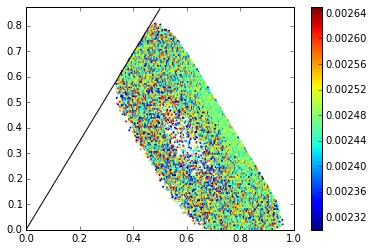

In [40]:
plt.plot(triang_x(td.ve,td.vmu,td.vtau),triang_y(td.ve,td.vmu,td.vtau),'k-')
plt.hexbin(triang_x(xdp.Y1e**2,xdp.Y1mu**2,xdp.Y1tau**2),triang_y(xdp.Y1e**2,xdp.Y1mu**2,xdp.Y1tau**2),np.abs(xdp.m_nu_3*1E9)**2,gridsize =200)
plt.colorbar()
plt.ylim(0,1.01*np.sqrt(3.)/2.)
plt.xlim(0,1)

(0, 1)

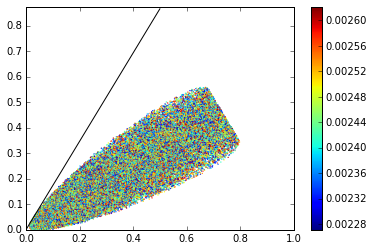

In [39]:
plt.plot(triang_x(td.ve,td.vmu,td.vtau),triang_y(td.ve,td.vmu,td.vtau),'k-')
plt.hexbin(triang_x(xip.Y1e**2,xip.Y1mu**2,xip.Y1tau**2),triang_y(xip.Y1e**2,xip.Y1mu**2,xip.Y1tau**2),np.abs(xip.m_nu_2*1E9)**2,gridsize =500)
plt.colorbar()
plt.ylim(0,1.01*np.sqrt(3.)/2.)
plt.xlim(0,1)

In [8]:
xdf

,Unnamed: 0,MA0,MH0,MHC,Mh,Mtr01,Mtr02,Mtr03,U_e1_i,U_e1_r,...,theta_3_r,y1e,y1mu,y1tau,y2e,y2mu,y2tau,y3e,y3mu,y3tau
0,0,434.459598,70,434.459598,125.09,432.598849,1479.023706,2681.750715,0,0.832352,...,2.754940,0.000001,0.000001,0.000002,0.000001,0.000001,0.000002,0.000001,0.000004,0.000003
1,1,176.997001,70,172.450603,125.09,869.417469,1781.432859,2108.119365,0,0.838071,...,2.541829,0.000003,0.000004,0.000005,0.000003,0.000004,0.000005,0.000001,0.000008,0.000005
2,2,526.569070,70,526.569070,125.09,737.918261,2044.726056,2286.598350,0,0.810542,...,0.197331,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000000,0.000003,0.000003
3,3,370.033019,70,370.033019,125.09,146.727421,729.357987,1131.442742,0,0.787149,...,4.738537,0.000001,0.000004,0.000003,0.000001,0.000004,0.000003,0.000001,0.000001,0.000001
4,4,330.150751,70,330.150751,125.09,997.179417,1444.856932,2937.396038,0,0.783738,...,2.104327,0.000002,0.000003,0.000004,0.000002,0.000003,0.000004,0.000001,0.000004,0.000003
5,5,487.475735,70,487.475735,125.09,654.855575,1820.051001,2748.074584,0,0.836790,...,5.272872,0.000000,0.000002,0.000003,0.000000,0.000002,0.000003,0.000001,0.000003,0.000001
6,6,134.196018,70,166.047727,125.09,504.545104,767.699438,2427.231928,0,0.794382,...,5.290238,0.000039,0.000088,0.000104,0.000039,0.000088,0.000104,0.000053,0.000121,0.000141
7,7,762.101946,70,762.101946,125.09,761.253054,1495.728258,2517.453980,0,0.799614,...,4.034693,0.000000,0.000002,0.000001,0.000000,0.000002,0.000001,0.000001,0.000001,0.000002
8,8,333.372900,70,333.372900,125.09,488.973429,2493.530004,2566.971112,0,0.812080,...,4.807704,0.000001,0.000005,0.000004,0.000001,0.000005,0.000004,0.000002,0.000002,0.000002
9,9,79.303834,70,97.598268,125.09,855.494289,2226.595142,2448.228768,0,0.788080,...,0.585791,0.000009,0.000027,0.000013,0.000009,0.000027,0.000013,0.000012,0.000022,0.000033
